In [ ]:
import numpy as np
import tensorflow as tf
import glob
import random
from sklearn import model_selection

from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, Input, Flatten
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle
import keras
from sklearn.metrics import f1_score
import cv2

import os
import shutil

In [ ]:
def trainClasses():
    trainClasses = set()
    with open("trainclasses.txt") as f:
        for line in f:
            trainClasses.add(line.strip())

    idxToClass = {}
    with open("classes.txt") as f:
        for line in f:
            idx, cname = line.strip().split("\t")
            idxToClass[int(idx)] = cname
    
    print("reading IO")
    
    classToY = {}
    with open("predicate-matrix-binary.txt") as f:
        for idx, line in enumerate(f):
            cname = idxToClass[idx+1]
            if cname in trainClasses:
                classToY[cname] = list(map(int, line.strip().split()))
                
    # kaze = cv2.KAZE_create()
    # kaze_vectors = {}
    # descriptor_list = []
    
    X = []
    Y = []

    counter = 0
    for className in trainClasses:
        print(className)
        features = []
        yvec = classToY[className]
        DATA_DIR = './animalPics/' + className
        for idx, filename in enumerate(os.listdir(DATA_DIR)):
            with open(os.path.join(DATA_DIR, filename), 'r') as f:
                npimg = np.fromfile(f, np.uint8)
                # if idx < 14:
                #     try:
                #         kp, des = kaze.detectAndCompute(finalimg, None)
                #         descriptor_list.extend(des)
                #         features.append(des)
                #     except:
                #         continue
                img = cv2.resize(cv2.imdecode(npimg, cv2.IMREAD_COLOR), (299, 299))
                with open(str(counter) + ".npy", "wb") as writefile:
                  np.save(writefile, np.array(img))
                # X.append(cv2.resize(cv2.imdecode(npimg, cv2.IMREAD_COLOR), (299, 299)))
                #np.save(writefile, np.array(yvec))
                Y.append(yvec)
            counter += 1
                  
          #kaze_vectors[className] = features
    
    X = np.array(X)
    Y = np.array(Y)

    print(X.shape)
    print(Y.shape)
    
    # return X, Y, idxToClass, kaze_vectors, descriptor_list
    return X, Y, idxToClass

In [ ]:
!unzip animalPics.zip

Streaming output truncated to the last 5000 lines.
  inflating: animalPics/deer/deer_10601.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_10601.jpg  
  inflating: animalPics/deer/deer_11279.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_11279.jpg  
  inflating: animalPics/deer/deer_10167.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_10167.jpg  
  inflating: animalPics/deer/deer_10173.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_10173.jpg  
  inflating: animalPics/deer/deer_10615.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_10615.jpg  
  inflating: animalPics/deer/deer_11245.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_11245.jpg  
  inflating: animalPics/deer/deer_11251.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_11251.jpg  
  inflating: animalPics/deer/deer_10629.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_10629.jpg  
  inflating: animalPics/deer/deer_10826.jpg  
  inflating: __MACOSX/animalPics/deer/._deer_10826.jpg  
  inflating: animalPic

In [ ]:
X, Y, idxToClass = trainClasses()

reading IO
tiger
weasel
chihuahua
gorilla
mouse
hamster
moose
beaver
wolf
zebra
skunk
polar+bear
siamese+cat
fox
horse
bobcat
killer+whale
antelope
squirrel
grizzly+bear
rhinoceros
german+shepherd
rabbit
lion
dolphin
giraffe
buffalo
blue+whale
sheep
collie
mole
otter
deer
walrus
bat
ox
spider+monkey
elephant
cow
dalmatian
(0,)
(30337, 85)


In [ ]:
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=5)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words, kmeans
    
# Takes the central points which is visual words    
visual_words, model = kmeans(2000, descriptor_list) 

In [ ]:
hists = []
classes1 = []
KAZE = cv.KAZE_create()

for key,value in images.items():
    for img in value:
        try:
            kp, des = KAZE.detectAndCompute(img,None)
            des_double = np.array(des, dtype=np.double)
            predict_kmeans = model.predict(des_double)
            #calculates the histogram
            hist, bin_edges = np.histogram(predict_kmeans, bins=2000)
            hists.append(hist)
            classes1.append(key)
        except:
            continue

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(299, 299), n_channels=3,
                 n_classes=40, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, 85), dtype=int)

        listSet = set(list_IDs_temp)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample

            Xtotal = np.load(str(ID) + '.npy', mmap_mode='r')
            X[i] = Xtotal

            # Store class
            y[i] = self.labels[ID]

        return X, y

IndexError: ignored

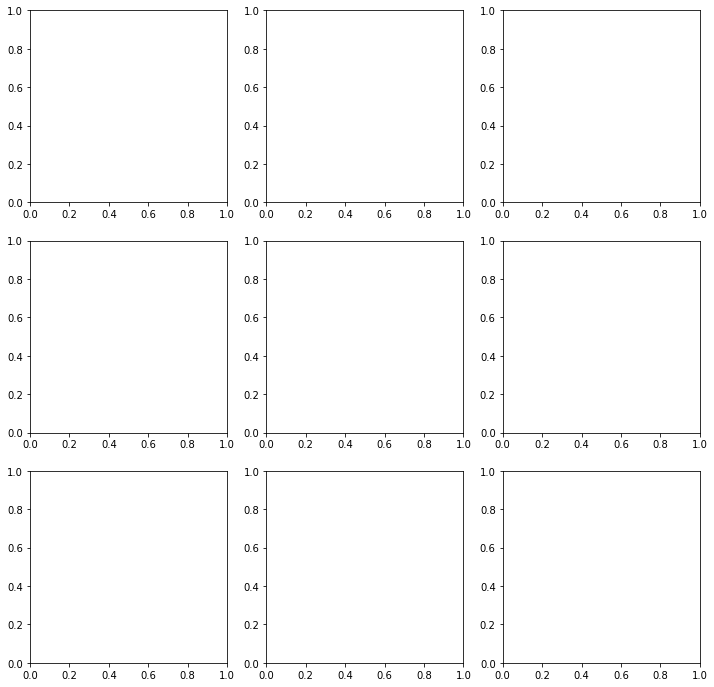

In [ ]:
attributeDict = {}

with open("predicates.txt") as f:
    for line in f:
        idx, att = line.strip().split()
        attributeDict[int(idx) - 1] = att
        
def getAttributeList(y):
    attSet = set()
    for i, val in enumerate(y):
        if val == 1:
            attSet.add(attributeDict[i])
    print(attSet)
    print()

fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
for i in range(9):
    draws[i].imshow(X[i*1000])
    getAttributeList(Y[i*1000])

In [ ]:
new_input = Input(shape=(299, 299, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=new_input)

"""
Freeze all inception layers
"""
# for idx, layer in enumerate(inception_model.layers):
#     if idx < len(inception_model.layers) // 2:
#       layer.trainable = False 

x = inception_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(85, activation='sigmoid')(x)

model = Model(inputs=inception_model.input, outputs=prediction)
model.summary()

batch_size = 32

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
top_epochs = 5
# Parameters
params = {'dim': (299, 299),
          'batch_size': 32,
          'n_classes': 40,
          'n_channels': 3,
          'shuffle': True}

training_generator = DataGenerator(range(len(Y)), Y, **params)
model.fit(training_generator, use_multiprocessing=True, workers=8, epochs=top_epochs)

Epoch 1/5
948/948 [==============================] - 301s 288ms/step - loss: 0.2736 - binary_accuracy: 0.8811
Epoch 2/5
948/948 [==============================] - 280s 288ms/step - loss: 0.1843 - binary_accuracy: 0.9229
Epoch 3/5
948/948 [==============================] - 276s 287ms/step - loss: 0.1452 - binary_accuracy: 0.9402
Epoch 4/5
948/948 [==============================] - 271s 283ms/step - loss: 0.1204 - binary_accuracy: 0.9513
Epoch 5/5
948/948 [==============================] - 276s 285ms/step - loss: 0.1005 - binary_accuracy: 0.9600


In [ ]:
Xtotal = np.load('0.npy', mmap_mode='r')
print(Xtotal.shape)
y_pred = model.predict(Xtotal.reshape(-1, 299, 299, 3))
print(y_pred)

x2 = np.load('20002.npy', mmap_mode='r')
print(model.predict(x2.reshape((-1, 299, 299, 3))))
print(Y[0])
print(Y[20002])

(299, 299, 3)
[[9.99726593e-01 9.99881148e-01 9.52225218e-06 6.42970408e-05
  6.54656324e-04 9.61517096e-01 1.52233213e-06 8.11051086e-06
  1.33449805e-03 1.34886627e-03 9.99182045e-01 9.99976039e-01
  6.16401527e-03 2.66273394e-02 9.99912262e-01 1.11820045e-04
  7.73441279e-04 9.99330878e-01 1.02099002e-04 1.42723356e-05
  1.87247675e-02 9.36057568e-01 9.83168960e-01 7.32608289e-02
  4.96384427e-02 9.99175966e-01 9.99971151e-01 9.85282660e-01
  9.91045654e-01 5.99408464e-04 5.45020448e-05 9.59467053e-01
  6.02797809e-05 9.82293427e-01 9.74869636e-06 5.42106827e-05
  2.30028745e-04 2.16657627e-05 9.99847889e-01 9.99792635e-01
  3.16399790e-04 9.99928355e-01 2.72062571e-05 9.99908209e-01
  4.47005703e-04 9.99973774e-01 9.99630332e-01 7.96666543e-04
  9.58569884e-01 2.09796257e-04 9.99814689e-01 4.83485084e-04
  9.84677672e-01 6.77939097e-05 6.63506007e-03 8.60766795e-06
  4.86537348e-03 1.21297082e-02 9.19971764e-01 3.43904394e-05
  9.39961956e-06 9.36486423e-01 1.65065657e-03 9.9925404

In [ ]:
def testClasses():
    fileList = []
    fileToLabel = {}
    with open("test_images.txt") as f:
        for line in f:
            path, label = line.strip().split()
            fileToLabel[path] = label
            fileList.append(path)
    
    testClasses = set()
    with open("testclasses.txt") as f:
        for line in f:
            testClasses.add(line.strip())
    
    classToY = {}
    with open("predicate-matrix-binary.txt") as f:
        for idx, line in enumerate(f):
            cname = idxToClass[idx+1]
            if cname in testClasses:
                classToY[cname] = list(map(int, line.strip().split()))
                
    X_test = []
    Y_test = []
    for file, label in fileToLabel.items():
        DATA_DIR = './animalPics/' + file
        with open(DATA_DIR, 'r') as f:
            npimg = np.fromfile(f, np.uint8)
            cvimg = cv2.imdecode(npimg, cv2.IMREAD_COLOR)
            X_test.append(cv2.resize(cvimg, (299, 299)))
            Y_test.append(classToY[label])
    
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    return X_test, Y_test, classToY, fileList

In [ ]:
X_test, Y_test, classToY, fileList = testClasses()

In [ ]:
def predict():
    print("predicting test data")
    y_pred = model.predict(X_test)
    
    print("choosing nearest neighbor")
    class_pred = []
    for i in range(len(y_pred)):
        yvec = y_pred[i]
        
        minDiff = 1000000000000000
        minName = "empty"
            
        for cname, Y in classToY.items():
            diff = np.sum(np.abs(Y - yvec))
            if diff < minDiff:
                minDiff = diff
                minName = cname
                
        class_pred.append(minName)
    return class_pred

In [ ]:
class_predict = predict()

predicting test data
choosing nearest neighbor


In [ ]:
print(class_predict)

['pig', 'chimpanzee', 'pig', 'chimpanzee', 'chimpanzee', 'chimpanzee', 'chimpanzee', 'leopard', 'persian+cat', 'persian+cat', 'leopard', 'persian+cat', 'leopard', 'chimpanzee', 'leopard', 'chimpanzee', 'chimpanzee', 'chimpanzee', 'persian+cat', 'persian+cat', 'chimpanzee', 'chimpanzee', 'leopard', 'persian+cat', 'leopard', 'chimpanzee', 'persian+cat', 'pig', 'chimpanzee', 'rat', 'leopard', 'rat', 'chimpanzee', 'rat', 'persian+cat', 'chimpanzee', 'chimpanzee', 'pig', 'persian+cat', 'chimpanzee', 'pig', 'pig', 'pig', 'chimpanzee', 'pig', 'rat', 'rat', 'persian+cat', 'persian+cat', 'leopard', 'chimpanzee', 'persian+cat', 'pig', 'persian+cat', 'persian+cat', 'rat', 'chimpanzee', 'leopard', 'pig', 'pig', 'pig', 'leopard', 'persian+cat', 'chimpanzee', 'seal', 'persian+cat', 'seal', 'rat', 'chimpanzee', 'rat', 'chimpanzee', 'chimpanzee', 'chimpanzee', 'chimpanzee', 'chimpanzee', 'persian+cat', 'leopard', 'rat', 'persian+cat', 'chimpanzee', 'pig', 'persian+cat', 'chimpanzee', 'chimpanzee', 'le

In [ ]:
def printFile():
    path = os.path.join(os.getcwd(), "manhattan.txt")
    print(path)
    with open(path, 'w') as f:
        for i in range(len(class_predict)):
            f.write(fileList[i] + " " + class_predict[i] + "\n")
        

In [ ]:
printFile()

/content/manhattan.txt


In [ ]:
from google.colab import files
files.download('/content/manhattan.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import argparse

import numpy as np
from collections import defaultdict

"""
Evalution script:

example execution:
    python eval_awa.py --gt test_images.txt --pred example_submission.txt

see example_submission.txt for correct submission format

"""
def labelToIdx(pred_label):
    idx = -1
    if pred_label == "chimpanzee":
        idx = 0
    elif pred_label == "giant+panda":
        idx = 1
    elif pred_label == "leopard":
        idx = 2
    elif pred_label == "persian+cat":
        idx = 3
    elif pred_label == "pig":
        idx = 4
    elif pred_label == "hippopotamus":
        idx = 5
    elif pred_label == "humpback+whale":
        idx = 6
    elif pred_label == "raccoon":
        idx = 7
    elif pred_label == "rat":
        idx = 8
    elif pred_label == "seal":
        idx = 9
    return idx

def read_animal_file(fname):
    image_label_dict = {}
    with open(fname) as f:
        for line in f:
            image, label = line.split()
            image_label_dict[image] = label

    return image_label_dict

infile = "test_images.txt"
predfile = "finalfile.txt"

gt_dict = read_animal_file(infile)
pred_dict = read_animal_file(predfile)

per_class_accuracy = {"all": []}
incorrect_accuracies = {"chimpanzee": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "giant+panda": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "leopard": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "persian+cat": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "pig": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "hippopotamus": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "humpback+whale": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "raccoon": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "rat": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        "seal": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

for image in gt_dict:
    if image not in pred_dict:
        print("Error: {} not in prediction file".format(image))
        raise Exception()

    gt_label = gt_dict[image]
    pred_label = pred_dict[image]

    idx = labelToIdx(pred_label)
    if gt_label == pred_label:
        per_class_accuracy["all"].append(1)
    else:
        per_class_accuracy["all"].append(0)
    incorrect_accuracies[gt_label][idx] += 1



print("Final Accuracy: {:.5f}".format(np.mean(per_class_accuracy["all"])))
percent_acc = {}
for key, list in incorrect_accuracies.items():
    percent_acc[key] = list[labelToIdx(key)]/sum(list)
print(incorrect_accuracies)
print(percent_acc)


FileNotFoundError: ignored